In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 7 17:11:49 2024

@author: acmsavazzi
"""
#%% GOES-16.py

#%%                             Libraries
###############################################################################
import numpy as np
import pandas as pd
import xarray as xr
import os
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.ticker import MaxNLocator, FuncFormatter
from datetime import datetime, timedelta
from netCDF4 import Dataset
import matplotlib.pylab as pylab
from skimage import measure
params = {'legend.fontsize': 'large',
         'axes.labelsize': 24,
         'axes.titlesize':'large',
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'figure.figsize':[10,7],
         'figure.titlesize':24}
pylab.rcParams.update(params)
import dask
import dask.array as da
dask.config.set({"array.slicing.split_large_chunks": True})
from intake import open_catalog

from dask.diagnostics import ProgressBar

In [2]:
max_BrT = 290 # K
min_BrT = 277 #K
my_data_dir = os.path.abspath('../../HARMONIE_paper/data')+'/'

In [3]:
## Get HARMONIE control 3d exp 
exp = 'HA43h22tg3_clim_noHGTQS'
harm3d_snap = xr.open_mfdataset(my_data_dir+exp+'/'+exp[16:]+'_harm3d_snapshots.nc',\
                                  combine='by_coords')
## Get EUREC4A catalogue
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

In [10]:
lat_min = harm3d_snap.lat.min()-0.01
lat_max = harm3d_snap.lat.max()+0.01
lon_min = harm3d_snap.lon.min()-0.01
lon_max = harm3d_snap.lon.max()+0.01
# data = xr.concat([cat.satellites.GOES16['latlongrid'](date=d).to_dask().chunk({"time": 2,'lat':500,'lon':500}) 
#                   for d in pd.date_range('2020-01-12','2020-02-14') 
#                   if d.strftime('%Y-%m-%d') not in ['2020-01-21', '2020-01-24']], dim='time')\
#                 .sel(lat=slice(lat_max,lat_min)).sel(lon=slice(lon_min,lon_max))

data = xr.concat([cat.satellites.GOES16['latlongrid'](date=d).to_dask().chunk({"time": 2,'lat':500,'lon':500}) 
                  for d in pd.date_range('2020-01-12','2020-01-13') 
                  if d.strftime('%Y-%m-%d') not in ['2020-01-21', '2020-01-24']], dim='time')\
                .sel(lat=slice(lat_max,lat_min)).sel(lon=slice(lon_min,lon_max))


In [11]:
## Select an image every 30 minutes
data_30min_delayed = data.isel(time=(data['time.minute'] == 0)| 
                       (data['time.minute'] == 30))

In [12]:
### Interpolate to HARMONIE grid will give 2.5km resolution 
data_interp_delayed = data_30min_delayed.interp(lat=harm3d_snap.lat.isel(x=40).values)\
                              .interp(lon=harm3d_snap.lon.isel(y=40).values)

In [14]:
## SLOW !!
with ProgressBar():
    data_computed = data_interp_delayed.compute()

[########################################] | 100% Completed | 60.08 s


In [106]:
## Remove images where the 25th percentile of brightness temperatures is lower than 285K
data_clean = data_computed.where(data_computed['C13'].quantile(0.25,
                                dim=('lat','lon'))>285,drop=True)

In [107]:
## find cloud mask 
data_clean['cl_mask'] = data_clean['C13'].where(
                (data_clean['C13']<max_BrT)&
                (data_clean['C13']>min_BrT),1,0)

In [111]:
print('Saving')
data_clean.attrs.pop("_NCProperties", None)
data_clean.to_netcdf(my_data_dir+'Goes16_interp.nc', compute=True)

Saving


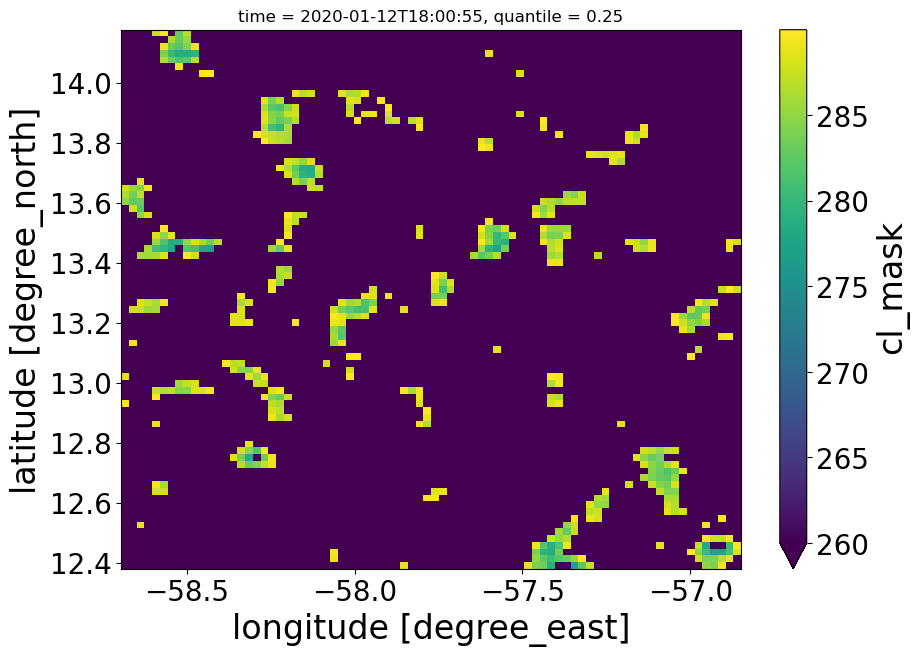

In [112]:
plt.figure()
data_clean.isel(time=10)['cl_mask'].plot(vmin=260)